## MNIST

In [4]:
from sklearn.datasets import fetch_openml

#이미지 데이터이므로 df 대신 as_frame=False로 통해 넘파이 배열로 반환
mnist=fetch_openml('mnist_784',as_frame=False) 

/Users/yoonsjin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yoonsjin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [5]:
X,y=mnist.data, mnist.target

In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

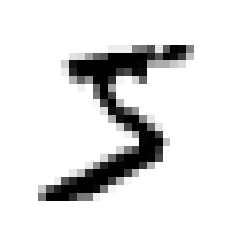

In [12]:
#이미지를 확인하는 방법
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image=image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
some_digit=X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

In [6]:
X_train, X_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:]

## 이진 분류기 훈련

In [8]:
y_train_5=(y_train=='5')
y_test_5=(y_test=='5')

In [9]:
#SGD

from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## 교차 검증을 사용한 정확도 측정

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
#모든 이미지를 가장 많이 등장하는 클래스(음성 클래스, '5가 아님')로 분류하는 더미 분류기 생성
from sklearn.dummy import DummyClassifier

dummy_clf=DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train))) #False: true로 예측된 것이 없음

False


In [16]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

## 오차 행렬을 사용한 정확도 측정

In [20]:
#실제 타깃과 비교할 수 있도록 예측값을 만들기(테스트 세트를 사용하지 않고)
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

KeyboardInterrupt: 

In [18]:
#실제 오차 행렬 만들기
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_train_5, y_train_pred)

In [19]:
cm

#첫번째 행: '5 아님' 이미지(음성 클래스, negative class)에 대한 진짜 음성(true negative)와 거짓 양성(false negative),1종 오류(type 1 error)
#두번째 행: '5' 이미지(양성 클래스, positive class)에 대한 거짓 음성(false negative),2종 오류(type 2 error)와 진짜 양성(true positive) 

array([[53892,   687],
       [ 1891,  3530]])

In [21]:
#완벽한 분류기일 경우
y_train_perfect_predictions=y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 정밀도와 재현율

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

## 정밀도/재현율 트레이드오프

In [14]:
#각 샘플의 점수를 얻기
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [16]:
threshold=0 #무조건 True를 반환
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [18]:
threshold=3000 #임곗값을 높일수록 재현율이 줄어듦
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

적절한 임곗값을 정하기

In [22]:
#훈련 세트에 있는 모든 샘플의 점수 구하기
from sklearn.model_selection import cross_val_predict

y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,
                          method="decision_function")

In [58]:
#함수를 이용해 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds=precision_recall_curve(y_train_5, y_scores)

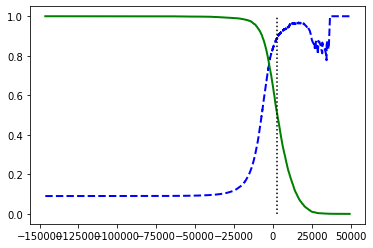

In [65]:
#임곗값의 함수로 정밀도와 재현율 그리기
plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="임곗값")

plt.show()